SETUP AND OBSERVATIONAL ANALYSIS

In [110]:
# Importing libraries/functions to be used
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import LSTM
from keras.api.layers import Dense
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [111]:
# Import dataset from yahoo finance consisting of [Date, Opening Price, Closing Price]
dataset = yf.download(tickers = "^GSPC", start="2023-10-26", end="2024-10-25")
dataset = dataset[['Open', 'Close']]
dataset = dataset.reset_index()
dataset

[*********************100%%**********************]  1 of 1 completed


,Date,Open,Close
0,2023-10-26,4175.990234,4137.229980
1,2023-10-27,4152.930176,4117.370117
2,2023-10-30,4139.390137,4166.819824
3,2023-10-31,4171.330078,4193.799805
4,2023-11-01,4201.270020,4237.859863
...,...,...,...
246,2024-10-18,5859.430176,5864.669922
247,2024-10-21,5857.819824,5853.979980
248,2024-10-22,5832.700195,5851.200195
249,2024-10-23,5834.500000,5797.419922


As of writing this, the dataset currently produces data from 2023-10-25 to 2024-10-24

In [112]:
# Transform the raw data into a pandas dataframe consisting of [Date, OPS]
# OPS = ((Opening Price - Closing Price of previous day) / Closing Price of previous day) * 100
# i.e. it refers to the percentage change in price overnight
ops = []
for i in range(1, len(dataset['Open'] + 1)):
    result = ((dataset['Open'][i] - dataset['Close'][i-1]) / dataset['Close'][i-1]) * 100
    ops.append(result)
ops = pd.DataFrame({'OPS': ops})

time_series = pd.concat([dataset['Date'], ops], axis=1)
time_series = time_series.dropna()
#time_series['OPS'] = time_series['OPS'].shift(1)
#time_series = time_series.drop(len(time_series)-1)
#time_series = time_series.drop(index=1)
#time_series = time_series.reset_index()
#time_series = time_series.drop(['index'], axis=1)
for i in range(len(time_series)):
    if time_series['OPS'][i] < -3:
        print(time_series['Date'][i])
        print(time_series['OPS'][i])
time_series

2024-08-02 00:00:00
-3.6550589488075302


,Date,OPS
0,2023-10-26,0.379486
1,2023-10-27,0.534808
2,2023-10-30,0.108242
3,2023-10-31,0.178125
4,2023-11-01,0.717341
...,...,...
245,2024-10-17,0.307456
246,2024-10-18,-0.116803
247,2024-10-21,-0.363510
248,2024-10-22,-0.285415


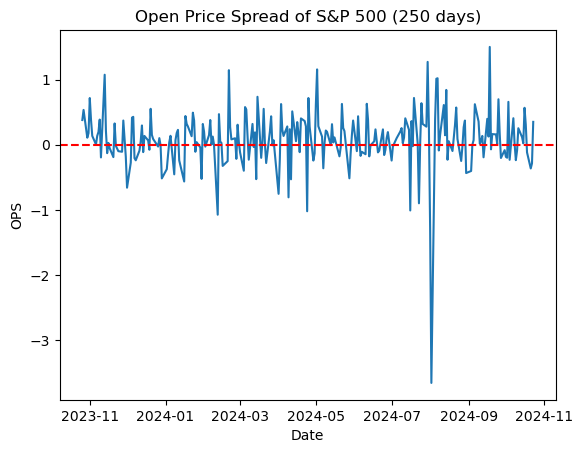

In [113]:
# Plotting the time series data (OPS) for observing trends and seasons
plt.plot(time_series['Date'], time_series['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

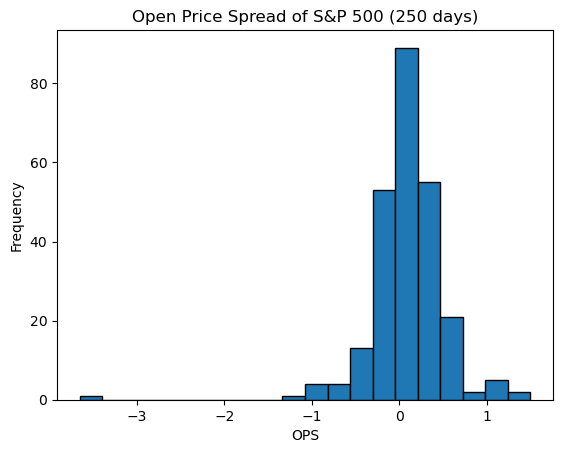

In [114]:
# Plotting the spread of OPS
plt.hist(time_series['OPS'], bins=20, edgecolor="black")
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

LSTM MODEL

This guide/tutorial was mostly used to help with the creation of this model:

Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras, Jason Brownlee, Machine Learning Mastery <https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/>

How to Tune LSTM Hyperparameters with Keras for Time Series Forecasting, Jason Brownlee, Machine Learning Mastery <https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/>

In [115]:
# Check to see if data is stationary using the Augmented Dicky Fuller Test (adfuller)
# Stationary data is required for timeseries analysis/prediction
data = time_series['OPS']
stationary_check = adfuller(data)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')

ADF Statistic:  -8.802209492008524
p-value:  2.0974456447278634e-14
Data is stationary


In [116]:
# The LSTM model requires a specific input, this function helps achieve this by creating two arrays where X is OPS at t, and Y is OPS at t+1
def XY_data(dataset, time_steps=1):
 X, Y = [], []
 for i in range(len(dataset)-time_steps-1):
    a = dataset[i:(i + time_steps), 0]
    X.append(a)
    Y.append(dataset[i + time_steps, 0])
 return np.array(X), np.array(Y)

In [117]:
# Dataset needs to be transformed to fit the model
dataset = data.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [118]:
# Set seed for reproducability 
tf.random.set_seed(10)

# Create accuracy table
accuracy_table = pd.DataFrame(columns=['Train:Test Split','Mean Squared Error','Mean Absolute Error', 'R-Squared Value'])
accuracy_table = accuracy_table.set_index('Train:Test Split')

In [119]:
# Split data into training and testing sets, 80:20 split 
train, test = train_test_split(dataset, test_size=0.20, shuffle=False)
print(len(dataset))
print(len(train))
print(len(test))

250
200
50


In [120]:
# Split into X (OPS at t) and Y (OPS at t+1) 
time_steps = 1 
trainX, trainY = XY_data(train, time_steps)
testX, testY = XY_data(test, time_steps)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

198
48
198
48


In [121]:
# Reshape data so it can fit the model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

A baseline model was needed for comparison with ARIMA model so it was decided through trial and error that all LSTM models would consist of the following parameters:

Layers: 1

Neurons: 4

Epochs: 100

Batch Size: 1

This can be customised further to help optimise the model however for this experiment's purpose it was not necessary.

Epoch 1/100


c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 - 2s - 8ms/step - loss: 0.2777
Epoch 2/100
198/198 - 0s - 2ms/step - loss: 0.0361
Epoch 3/100
198/198 - 0s - 2ms/step - loss: 0.0089
Epoch 4/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 5/100
198/198 - 0s - 2ms/step - loss: 0.0087
Epoch 6/100
198/198 - 0s - 1ms/step - loss: 0.0087
Epoch 7/100
198/198 - 0s - 2ms/step - loss: 0.0087
Epoch 8/100
198/198 - 0s - 1ms/step - loss: 0.0087
Epoch 9/100
198/198 - 0s - 1ms/step - loss: 0.0087
Epoch 10/100
198/198 - 0s - 2ms/step - loss: 0.0087
Epoch 11/100
198/198 - 0s - 2ms/step - loss: 0.0087
Epoch 12/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 13/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 14/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 15/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 16/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 17/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 18/100
198/198 - 0s - 1ms/step - loss: 0.0086
Epoch 19/100
198/198 - 0s - 2ms/step - loss: 0.0086
Epoch 20/100
198/198 - 0s - 2ms/s

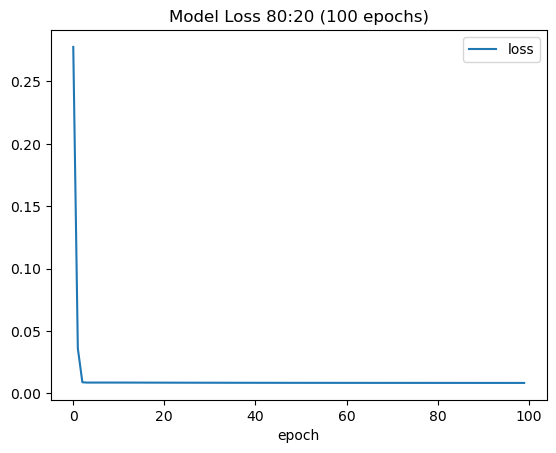

In [122]:
# Fitting model
model = Sequential()
model.add(LSTM(4, input_shape=(1, time_steps)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.title('Model Loss 80:20 (100 epochs)')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [123]:
# Make prediction
prediction = model.predict(testX)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [124]:
# Inverse the transformation
prediction = scaler.inverse_transform(prediction)
testY = scaler.inverse_transform([testY])

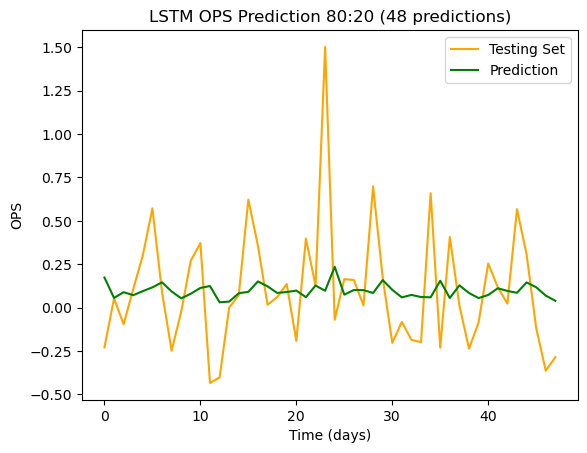

In [125]:
# Plot prediction
plt.plot(testY[0], label='Testing Set', color='orange')
plt.plot(prediction[:,0], label='Prediction', color='green')
plt.title('LSTM OPS Prediction 80:20 (' + str(len(prediction[:,0])) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()


In [126]:
# Evaluate
mse = (mean_squared_error(testY[0], prediction[:,0]))
mae = (mean_absolute_error(testY[0], prediction[:,0]))
r2 = (r2_score(testY[0], prediction[:,0]))
accuracy_table.loc["80:20"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.121559,0.252856,-0.012338


LSTM for 90:10 95:5 97.5:2.5

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


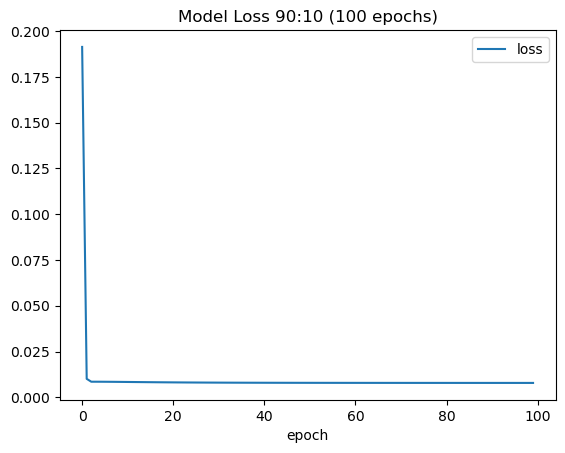

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


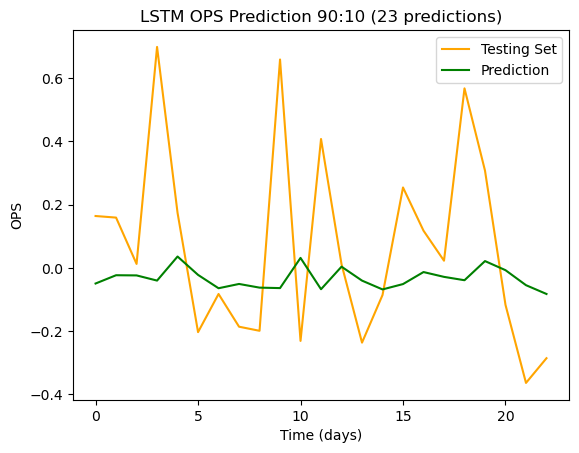

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


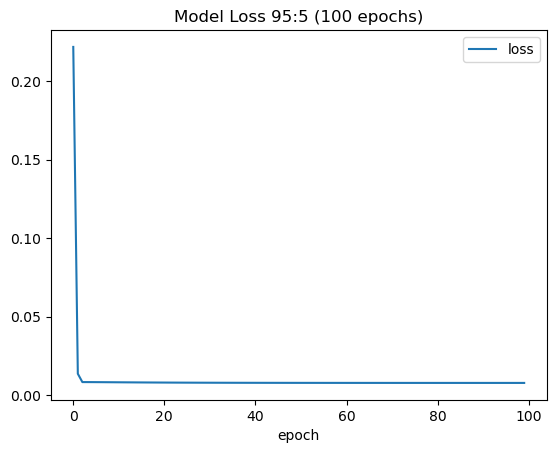

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


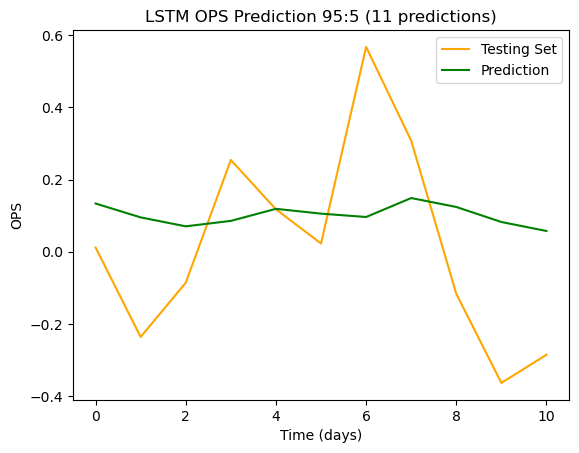

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


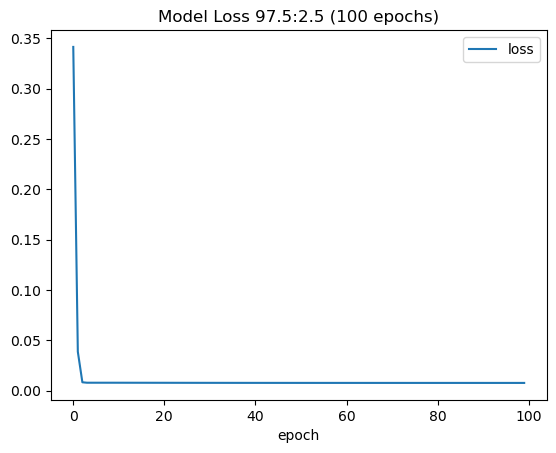

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


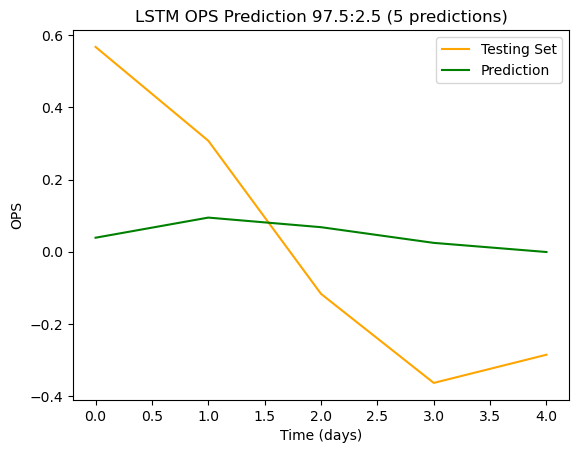

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.121559,0.252856,-0.012338
90:10,0.099134,0.237418,-0.126239
95:5,0.073257,0.229226,-0.029744
97.5:2.5,0.118085,0.319774,0.079370


In [127]:
#Repeating experiement

#epochs = [100, 500, 1000]
sample_size = [0.1, 0.05, 0.025] # 10% 5% 2.5%
sample_sizeS = ["90:10", "95:5", "97.5:2.5"]

# Repeat 3 times
for i in range(3):
    # Split data according to sample_size
    train, test = train_test_split(dataset, test_size=sample_size[i], shuffle=False)

    # Split into X and Y
    time_steps = 1
    trainX, trainY = XY_data(train, time_steps)
    testX, testY = XY_data(test, time_steps)

    # Reshape data
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Fit model
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, time_steps)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.title('Model Loss ' + sample_sizeS[i] + ' (100 epochs)')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    # Predict
    prediction = model.predict(testX)

    # Inverse Transformation
    prediction = scaler.inverse_transform(prediction)
    testY = scaler.inverse_transform([testY])

    # Evaluation
    mse = (mean_squared_error(testY[0], prediction[:,0]))
    mae = (mean_absolute_error(testY[0], prediction[:,0]))
    r2 = (r2_score(testY[0], prediction[:,0]))

    # Plot results
    plt.plot(testY[0], label='Testing Set', color='orange')
    plt.plot(prediction[:,0], label='Prediction', color='green')
    plt.title('LSTM OPS Prediction ' + sample_sizeS[i] + ' (' + str(len(prediction[:,0])) + ' predictions)')
    plt.xlabel('Time (days)')
    plt.ylabel('OPS')
    plt.legend()
    plt.show()

    # Add to accuracy table
    accuracy_table.loc[sample_sizeS[i]] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}

# Show accuracy table
accuracy_table